In [1]:
import pandas as pd
import glob
from tqdm import tqdm
import os
import numpy as np
import holidays
from datetime import datetime, timezone, timedelta

In [2]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)

    a = (math.sin(dlat / 2) ** 2 +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

def compute_distance(group):
    first_row = group.iloc[0]
    last_row = group.iloc[-1]
    return haversine_distance(first_row['0'], first_row['1'], last_row['0'], last_row['1'])

In [3]:
us_holidays = holidays.US(years=datetime.now().year, state='CA')

In [4]:
data_path = './../data_cabspotting/'

file_paths = glob.glob(data_path + 'processed_*.csv')

dfs = []

for file_path in tqdm(file_paths):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df = df[df['trip_id'] > -0.5]
        df = df.sort_values(by=['trip_id', '3'])
        distances = df.groupby('trip_id').apply(compute_distance).reset_index()
        distances.columns = ['trip_id', 'distance_end_start']
        timespent = df.groupby('trip_id')['time_diff'].sum().reset_index()
        timespent.columns = ['trip_id', 'time_spent']
        distance_total = df.groupby('trip_id')['distance_km'].sum().reset_index()
        distance_total.columns = ['trip_id', 'distance_total']

        
        df = df.drop(columns=['0', '1'])
        df['count'] = df.groupby('trip_id')[['trip_id']].transform('count')  
        df = df.drop_duplicates(subset=['trip_id','driver'], keep='first')
        df = df.merge(distances, on=['trip_id'], how='left')
        df = df.merge(timespent, on=['trip_id'], how='left')
        df = df.merge(distance_total, on=['trip_id'], how='left')
        
        df['3'] = pd.to_datetime(df['3'])
        df['date_start'] = df['3'].dt.date
        df['time_start'] = df['3'].apply(lambda x: x.hour * 60 + x.minute)
        df['day_of_Week'] = df['3'].dt.weekday

        # Check if the date is a holiday and convert to integer
        df['is_Holiday'] = df['date_start'].apply(lambda x: int(x in us_holidays))
        
        
        dfs.append(df)
        
df_full = pd.concat(dfs, axis=0, ignore_index=True)

100%|██████████████████████████████████████████████████████████████| 536/536 [04:01<00:00,  2.22it/s]


In [6]:
df_full = df_full.drop(columns=['3','distance_km'])

In [7]:
df_full['time_spent'] = np.where((df_full['time_spent']<-1400) & (df_full['time_spent']>-1440), 
                            df_full['time_spent'] + 1440, 
                            df_full['time_spent'])

In [8]:
df_full.shape

(1580965, 12)

In [9]:
df_full.to_csv('features_per_trip.csv', index=False)

In [10]:
df_full = pd.read_csv('features_per_trip.csv')

In [11]:
df_full = df_full[df_full['time_spent']>60*3]
df_full = df_full[df_full['time_spent']<60*120]

df_full = df_full[df_full['distance_total']/df_full['time_spent'] > (7/3600)]
df_full = df_full[df_full['distance_total']/df_full['time_spent'] < (150/3600)]

df_full = df_full[df_full['distance_total']/df_full['count'] < 2.5]

df_full = df_full[df_full['count'] > 3.5]

df_full = df_full[df_full['distance_end_start']/df_full['distance_total'] > 0.2]

In [12]:
df_full.shape

(752341, 12)

In [13]:
df_full.to_csv('features_per_trip_clean.csv', index=False)

In [14]:
df_full = pd.read_csv('features_per_trip_clean.csv')

In [15]:
f1 = df_full['time_spent'] >= 60*5
f3 = df_full['distance_total'] >= 1
df_full = df_full[df_full['count'] > 10]
#f4 = df_full['distance_km']/df_full['time_spent'] >= 0.15

In [16]:
df_full = df_full[f1 & f3]

/tmp/ipykernel_52881/3448802588.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_full = df_full[f1 & f3]


In [17]:
df_full.shape

(263106, 12)

In [18]:
df_full.to_csv('features_per_trip_useful.csv', index=False)

In [19]:
df_full = pd.read_csv('features_per_trip_useful.csv')

<AxesSubplot: >

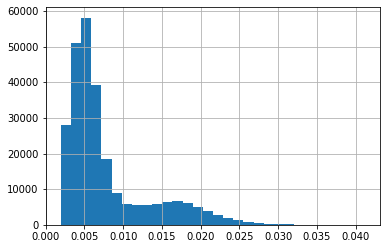

In [20]:
(df_full['distance_total']/df_full['time_spent']).hist(bins=30)

<AxesSubplot: >

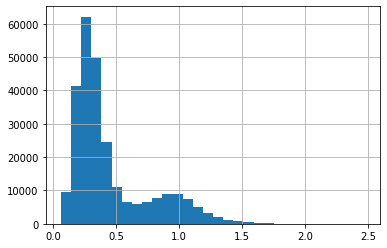

In [21]:
(df_full['distance_total']/df_full['count']).hist(bins=30)

<AxesSubplot: >

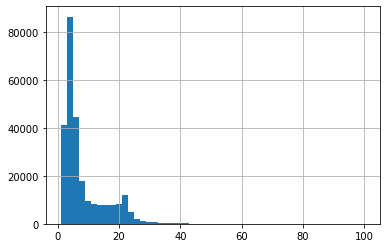

In [22]:
df_full['distance_total'].hist(bins=50)

<AxesSubplot: >

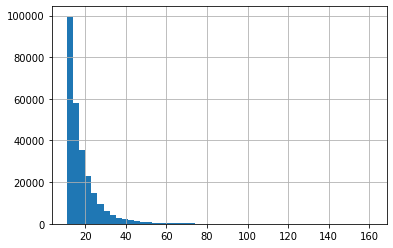

In [23]:
df_full['count'].hist(bins=50)

<AxesSubplot: >

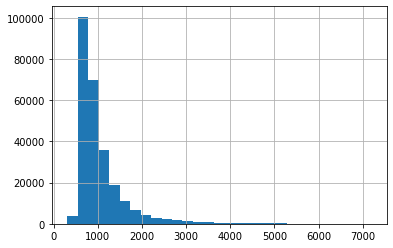

In [24]:
df_full['time_spent'].hist(bins=29)